In [61]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [457]:
def count_plot(df, x1, x2):
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    data = np.zeros([len(x1_candidate), len(x2_candidate)])
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            data[i][j] = len(df[df[x1] == x1_candidate[i]][df[x2] == x2_candidate[j]])
            
    return pd.DataFrame(data, columns=x2_candidate, index=x1_candidate)
    
def normalize(df, axis=1):
    if -1 in df.columns:
        n_sum = np.array(list(df.sum(axis) - df[-1]))
    else:
        n_sum = np.array(list(df.sum(axis)))

    if axis == 1:
        return df / n_sum.reshape(-1, 1)
    elif axis == 0:
        return df / n_sum.reshape(1, -1)
    
def mapping(n):
    if n == 1:
        return 'Synthesizable'
    else:
        return 'Unsynthesizable'
    
def modify(n):
    if n == 1:
        return 1
    else:
        return 0
    
def plot_curve(label, df_temp, start, stop, jump):
    ps = []
    sas = []
    i = start
    gap = jump
    while i < stop:
        sas.append(i)
        temp = df_temp[df_temp[label] > i][df_temp[label] <= i+gap]
        if len(temp) == 0:
            p = 0
        else:
            p = temp.tb_synthesizability.sum() / len(temp)
        ps.append(p)
        i += gap
        
    return sas, ps

def plot_curve_bar(label, df_temp, start, stop, jump):
    ps = []
    sas = []
    count = []
    i = start
    gap = jump
    while i < stop:
        sas.append(i)
        temp = df_temp[df_temp[label] > i][df_temp[label] <= i+gap]
        if len(temp) == 0:
            p = 0
        else:
            p = temp.tb_synthesizability.sum() / len(temp)
        ps.append(p)
#         count.append(len(temp) / len(df_temp))
        count.append(len(temp))
        i += gap
        
    return sas, ps, count

def make_pivot(df, name='property'):
    data = []
    sources = list(set(df.method))
    props = list(set(df.property))
    for source in sources:
        tmp_data = []
        for prop in props:
            tmp_data.append(len(df[df['method'] == source][df['property'] == prop][df['tb_synthesizability'] == 1]) \
                            / len(df[df['method'] == source][df['property'] == prop]))
        data.append(tmp_data)
        
    df_temp = pd.DataFrame(np.array(data), index=sources, columns=props)
    df_temp.index.name = 'method'
    df_temp.columns.name = name
    return df_temp

def calc_avg(df, threshold, x1, x2):
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    data = np.zeros([len(x1_candidate), len(x2_candidate)])
    df_temp = df[df['rank'] <= threshold]
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            tmp = df_temp[df_temp[x1] == x1_candidate[i]][df_temp[x2] == x2_candidate[j]]
            if len(tmp) == threshold:
                data[i][j] = tmp.objective.mean()
            else:
                data[i][j] = np.nan
            
    return pd.DataFrame(data, columns=x2_candidate, index=x1_candidate)

def make_synth_data(df, x1='property', x2='method'):
    df_synth = df[df['tb_synthesizability'] == 1]
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    dfs = []
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            df_temp = df_synth[df_synth[x1] == x1_candidate[i]][df_synth[x2] == x2_candidate[j]]
            df_temp['rank'] = list(range(1, len(df_temp) + 1))
            dfs.append(df_temp)
    return pd.concat(dfs)

def make_annot(df1, df2):
    df_temp = df1.copy()
    for i in range(len(df1.index)):
        for j in range(len(df1.columns)):
            df_temp.iloc[i, j] = str(df1.iloc[i, j])[:4] + '/' + str(df2.iloc[i, j])[:4]
    return df_temp

def make_ratio(df1, df2, name='name'):
    df_temp = df1.copy()
    for i in range(len(df1.index)):
        for j in range(len(df1.columns)):
            if not np.isnan(df1.iloc[i, j]) and np.isnan(df2.iloc[i, j]):
                df_temp.iloc[i, j] = 1.2
            elif np.isnan(df1.iloc[i, j]):
                df_temp.iloc[i, j] = 0
            else:
                df_temp.iloc[i, j] = df1.iloc[i, j] / df2.iloc[i, j]
    df_temp.index.name = 'property'
    df_temp.columns.name = name
    return df_temp

def heatmap(data, row_labels, col_labels, ax=None, set_cbar=True,
            cbar_kw={}, cbarlabel="", font_size=8, set_xlabel=True, set_ylabel=True,  **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    if set_cbar:
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.tick_params(labelsize=font_size)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", size=font_size)
    else:
        cbar = 0

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    if set_xlabel and set_ylabel:
        ax.tick_params(top=False, bottom=True, left=True, right=False,
                       labeltop=False, labelbottom=True, labelleft=True, labelright=False, labelsize=font_size)

    elif set_xlabel and (not set_ylabel):
        ax.tick_params(top=False, bottom=True, left=False, right=False,
                       labeltop=False, labelbottom=True, labelleft=False, labelright=False, labelsize=font_size)
        
    elif (not set_xlabel) and set_ylabel:
        ax.tick_params(top=False, bottom=False, left=True, right=False,
                       labeltop=False, labelbottom=False, labelleft=True, labelright=False, labelsize=font_size)
        
    elif (not set_xlabel) and (not set_ylabel):
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                       labeltop=False, labelbottom=False, labelleft=False, labelright=False, labelsize=font_size)
        
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=font_size / 3)
    ax.tick_params(which="minor", bottom=False, left=False, labelsize=font_size)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_change(synth, obj, obj_synth, x_labels, baseline, ax1=None, set_cbar=True, set_y1=False, y1_label="Objective", set_y2=False, 
                y2_label="Synthesizability", set_x=True, cbar_kw={}, cbarlabel="", font_size=8, set_title=True, title="", **kwargs):
    
    x = np.array([1, 2])
#     all_ys = list(synth) + list(obj_synth) + [0, 1]
    all_ys = [0, 0.5, 1]
    ax2 = ax1.twinx()
    ax1.plot(x, synth, color='green', marker='o', linestyle='-', linewidth=5, markersize=12)
    ax2.plot(x, obj_synth, color='red', marker='o', linestyle='-', linewidth=5, markersize=12)
    ax2.plot(x, obj, color='red', marker='o', linestyle='dashed', linewidth=5, markersize=12)

    ax1.plot(np.arange(0, 4), [baseline for x in np.arange(0, 4)], color='green', marker='', linestyle='dashed', linewidth=5, markersize=12)

    ax1.set_xlim(0.7, 2.3)
    ax1.set_xticks(np.arange(1, 3))
    ax1.set_xticklabels(x_labels)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks(np.array(all_ys))
    if set_y1:
        ax1.set_ylabel(y1_label, size=font_size)
    ax1.yaxis.tick_left()
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.set_tick_params(color='red')

    ax2.set_ylim(-0.1, 1.1)
    ax2.set_yticks(np.array(all_ys))
    if set_y2:
        ax2.set_ylabel(y2_label, size=font_size)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    ax1.grid(axis='y')

    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax1.spines['left'].set_color('red')
    ax2.spines['left'].set_color('red')
    ax1.spines['left'].set_linewidth(5)
    ax2.spines['left'].set_linewidth(5)

    ax1.spines['right'].set_color('green')
    ax2.spines['right'].set_color('green')
    ax1.spines['right'].set_linewidth(5)
    ax2.spines['right'].set_linewidth(5)

    ax1.spines['bottom'].set_linewidth(5)
    ax2.spines['bottom'].set_linewidth(5)

    plt.setp(ax1.get_xticklabels(), rotation=15, ha="center", rotation_mode="default")

    if set_x:
        ax1.tick_params(labelbottom=True, labelsize=font_size)
    else:
        ax1.tick_params(labelbottom=False, labelsize=font_size)
    ax2.tick_params(labelsize=font_size)

    if set_title:
        ax1.set_title(title, size=font_size)

    return None

def rename_trivial(df):
    df = df.rename(index={
        'smiles_lstm': 'SMILES LSTM',
        'smiles_ga': 'SMILES GA',
        'graph_ga': 'Graph GA',
        'best_from_chembl': 'Best from Data'
    })
    df = df.reindex(columns=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
    return df

def rename_trivial_obj(df):
    df = df.T
    df = df.rename(index={
        'smiles_lstm': 'SMILES LSTM',
        'smiles_ga': 'SMILES GA',
        'graph_ga': 'Graph GA',
        'best_from_chembl': 'Best from Data'
    })
    df = df.reindex(columns=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
    return df

def rename_hard(df):
    df = df.rename(index={
        'smiles_lstm': 'SMILES LSTM',
        'smiles_ga': 'SMILES GA',
        'graph_ga': 'Graph GA',
        'best_from_chembl': 'Best from Data'
    })
    df = df.reindex(columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
                             'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO'], index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
    return df

def rename_hard_obj(df):
    df = df.T
    df = df.rename(index={
        'smiles_lstm': 'SMILES LSTM',
        'smiles_ga': 'SMILES GA',
        'graph_ga': 'Graph GA',
        'best_from_chembl': 'Best from Data'
    })
    df = df.reindex(columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
                             'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO'], index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
    return df

In [169]:
df_goal_trivial_cwo = pd.read_csv('./data/chembl_wo.csv')
df_goal_trivial_cwa = pd.read_csv('./data/chembl_wa.csv')
df_goal_trivial_cwc = pd.read_csv('./data/chembl_wc.csv')

df_goal_trivial_mwo = pd.read_csv('./data/moses_wo.csv')
df_goal_trivial_mwa = pd.read_csv('./data/moses_wa.csv')
df_goal_trivial_mwc = pd.read_csv('./data/moses_wc.csv')

df_goal_hard_cwo = pd.read_csv('./data/goal_hard_cwo.csv')
df_goal_hard_cwa = pd.read_csv('./data/goal_hard_cwa.csv')
df_goal_hard_cwc = pd.read_csv('./data/goal_hard_cwc.csv')

df_goal_hard_mwo = pd.read_csv('./data/goal_hard_mwo.csv')
df_goal_hard_mwa = pd.read_csv('./data/goal_hard_mwa.csv')
df_goal_hard_mwc = pd.read_csv('./data/goal_hard_mwc.csv')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


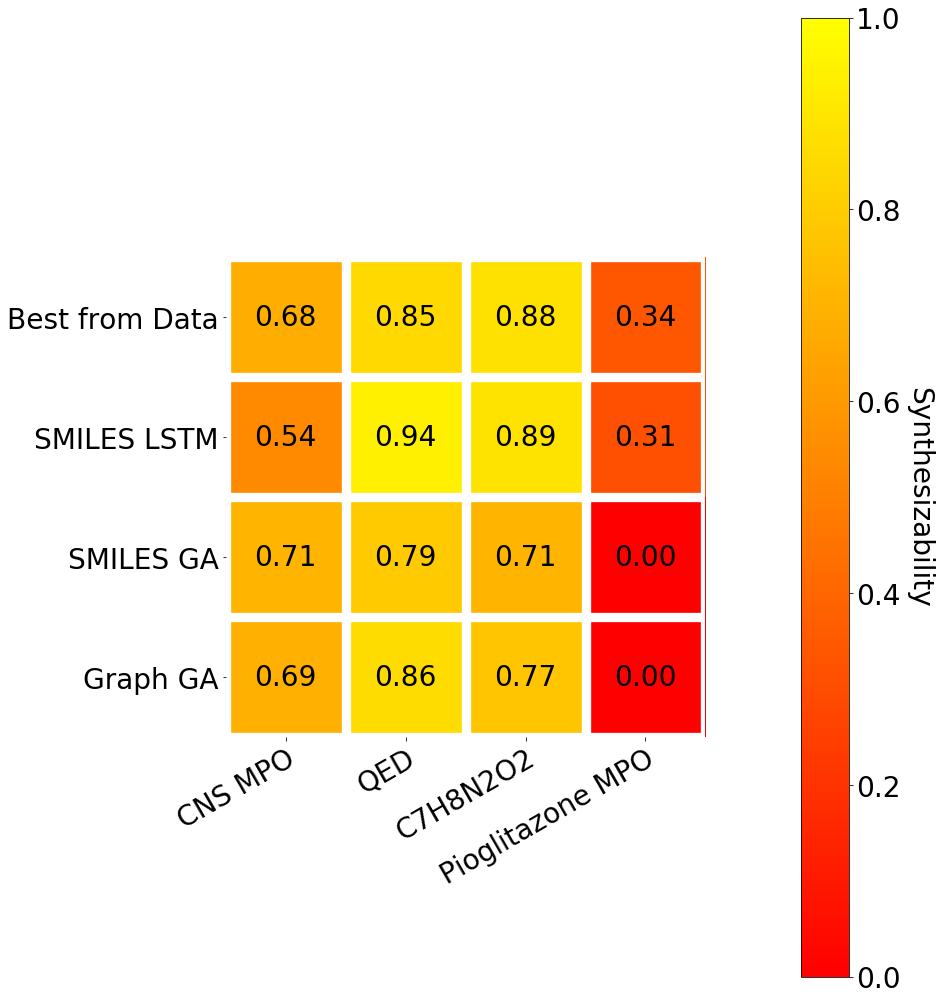

In [273]:
fig, ax = plt.subplots(figsize=(30, 30))

df_goal_pivot = make_pivot(df_goal_trivial_cwo, name='ChemBL original')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)

im, cbar = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax, cbar_kw={'fraction': 0.15, 'shrink': 2, 'aspect': 20, 'pad': 0.05}, vmin=0, vmax=1,
                   cmap="autumn", cbarlabel="Synthesizability", font_size=28)
texts = annotate_heatmap(im, valfmt="{x:.2f}", size=28)

fig.tight_layout()
# plt.show()
plt.savefig('./figure/heatmap_goal_colorbar.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


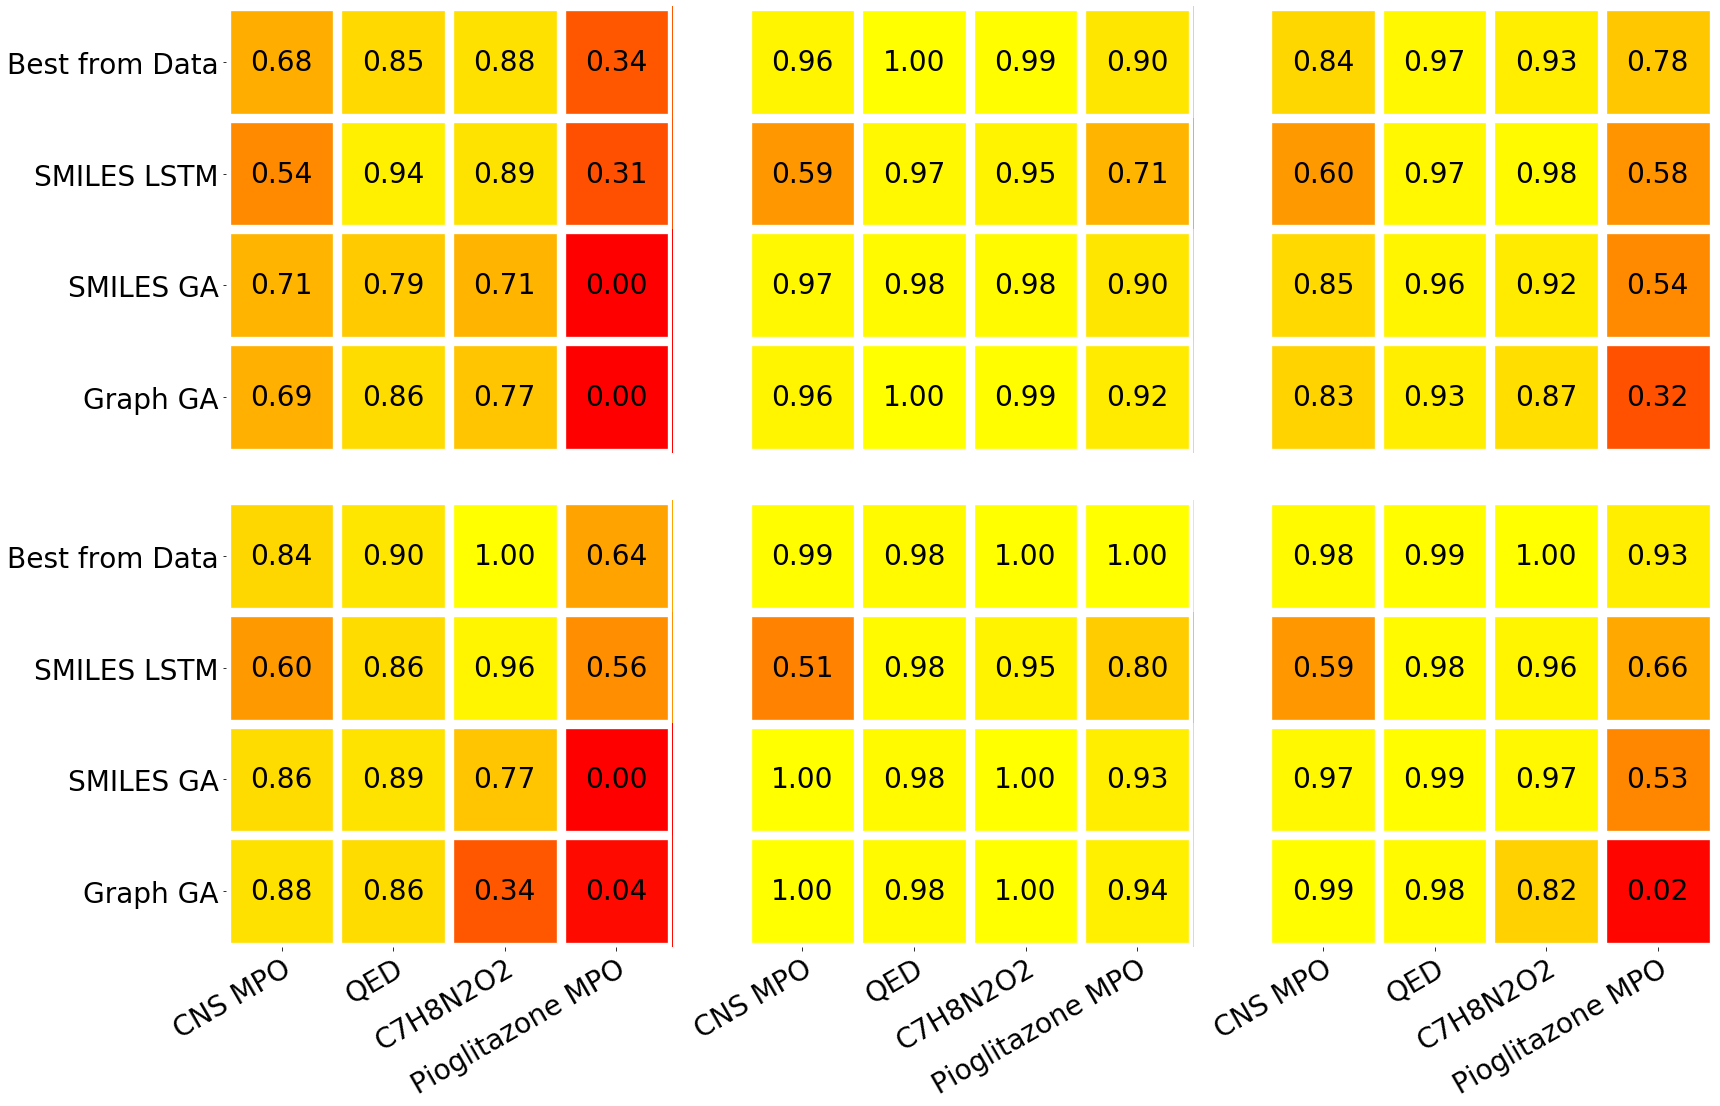

In [271]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

shrink = 1
aspect = 15
cmap = "autumn"
font_size = 28

df_goal_pivot = make_pivot(df_goal_trivial_cwo, name='ChemBL original')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax1, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_trivial_cwa, name='ChemBL with SA')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax2, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_trivial_cwc, name='ChemBL with SC')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax3, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_trivial_mwo, name='MOSES original')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax4, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_trivial_mwa, name='MOSES with SA')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax5, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_trivial_mwc, name='MOSES with SC')
# df_goal_pivot = df_goal_pivot.T
df_goal_pivot = rename_trivial(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax6, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)



plt.tight_layout()
# plt.show()
plt.savefig('./figure/heatmap_goal_trivial.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


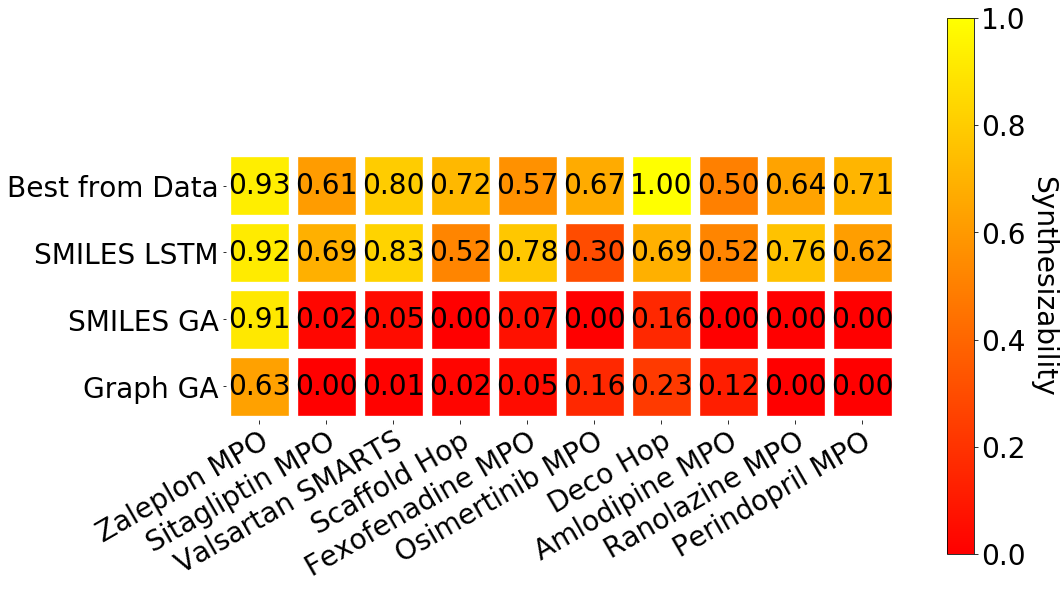

In [249]:
fig, ax = plt.subplots(figsize=(18, 18))

df_goal_pivot = make_pivot(df_goal_hard_cwo, name='ChemBL original')
df_goal_pivot = rename_hard(df_goal_pivot)

im, cbar = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax, cbar_kw={'fraction': 0.15, 'shrink': 2, 'aspect': 20, 'pad': 0.05}, vmin=0, vmax=1,
                   cmap="autumn", cbarlabel="Synthesizability", font_size=28)
texts = annotate_heatmap(im, valfmt="{x:.2f}", size=28)

fig.tight_layout()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


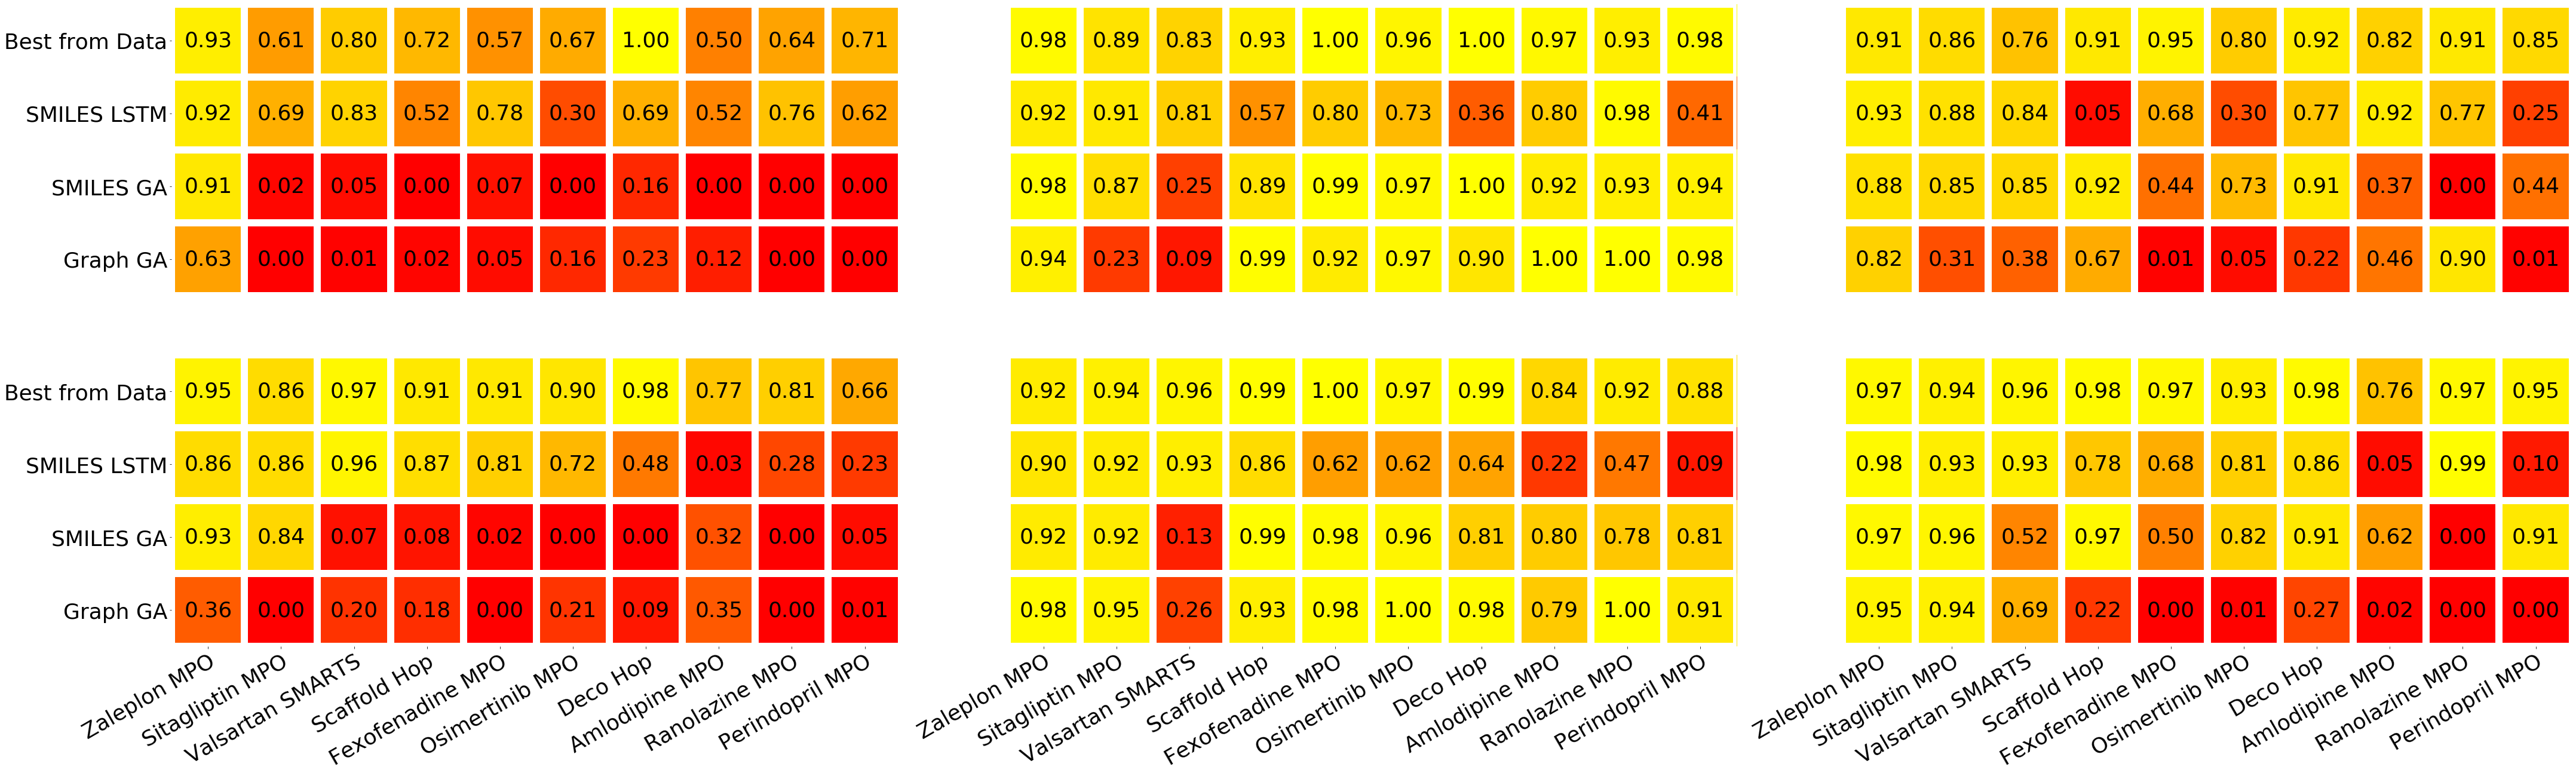

In [274]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(60, 20))

shrink = 1
aspect = 15
cmap = "autumn"
font_size = 36

df_goal_pivot = make_pivot(df_goal_hard_cwo, name='ChemBL original')
df_goal_pivot = rename_hard(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax1, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_hard_cwa, name='ChemBL with SA')
df_goal_pivot = rename_hard(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax2, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_hard_cwc, name='ChemBL with SC')
df_goal_pivot = rename_hard(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax3, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_hard_mwo, name='MOSES original')
df_goal_pivot = rename_hard(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax4, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_hard_mwa, name='MOSES with SA')
df_goal_pivot = rename_hard(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax5, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = make_pivot(df_goal_hard_mwc, name='MOSES with SC')
df_goal_pivot = rename_hard(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax6, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)



plt.tight_layout()
# plt.show()
plt.savefig('./figure/heatmap_goal_hard.png')

In [367]:
threshold = 10

df_goal_trivial_cwo_synth = make_synth_data(df_goal_trivial_cwo)
df_goal_trivial_cwa_synth = make_synth_data(df_goal_trivial_cwa)
df_goal_trivial_cwc_synth = make_synth_data(df_goal_trivial_cwc)

df_goal_trivial_mwo_synth = make_synth_data(df_goal_trivial_mwo)
df_goal_trivial_mwa_synth = make_synth_data(df_goal_trivial_mwa)
df_goal_trivial_mwc_synth = make_synth_data(df_goal_trivial_mwc)

df_goal_trivial_cwo_s10 = calc_avg(df_goal_trivial_cwo_synth, threshold, 'property', 'method')
df_goal_trivial_cwa_s10 = calc_avg(df_goal_trivial_cwa_synth, threshold, 'property', 'method')
df_goal_trivial_cwc_s10 = calc_avg(df_goal_trivial_cwc_synth, threshold, 'property', 'method')

df_goal_trivial_mwo_s10 = calc_avg(df_goal_trivial_mwo_synth, threshold, 'property', 'method')
df_goal_trivial_mwa_s10 = calc_avg(df_goal_trivial_mwa_synth, threshold, 'property', 'method')
df_goal_trivial_mwc_s10 = calc_avg(df_goal_trivial_mwc_synth, threshold, 'property', 'method')

df_goal_hard_cwo_synth = make_synth_data(df_goal_hard_cwo)
df_goal_hard_cwa_synth = make_synth_data(df_goal_hard_cwa)
df_goal_hard_cwc_synth = make_synth_data(df_goal_hard_cwc)

df_goal_hard_mwo_synth = make_synth_data(df_goal_hard_mwo)
df_goal_hard_mwa_synth = make_synth_data(df_goal_hard_mwa)
df_goal_hard_mwc_synth = make_synth_data(df_goal_hard_mwc)

df_goal_hard_cwo_s10 = calc_avg(df_goal_hard_cwo_synth, threshold, 'property', 'method')
df_goal_hard_cwa_s10 = calc_avg(df_goal_hard_cwa_synth, threshold, 'property', 'method')
df_goal_hard_cwc_s10 = calc_avg(df_goal_hard_cwc_synth, threshold, 'property', 'method')

df_goal_hard_mwo_s10 = calc_avg(df_goal_hard_mwo_synth, threshold, 'property', 'method')
df_goal_hard_mwa_s10 = calc_avg(df_goal_hard_mwa_synth, threshold, 'property', 'method')
df_goal_hard_mwc_s10 = calc_avg(df_goal_hard_mwc_synth, threshold, 'property', 'method')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


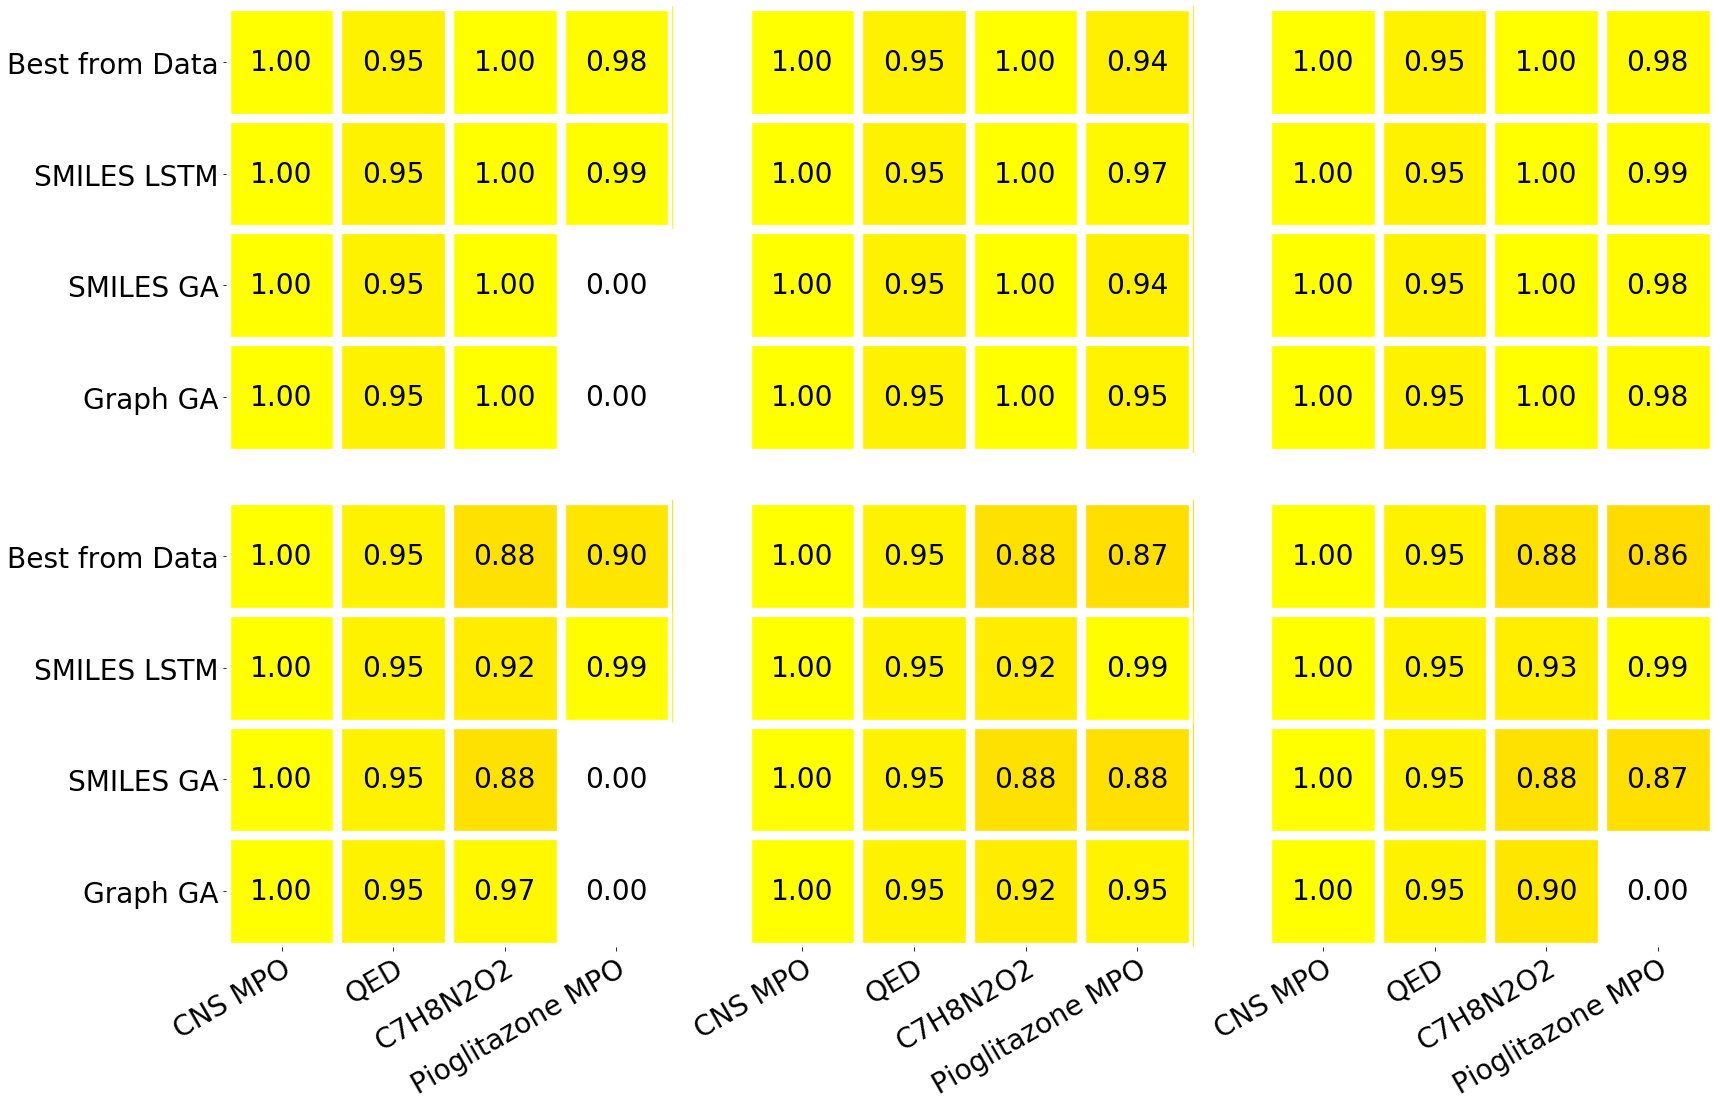

In [368]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

shrink = 1
aspect = 15
cmap = "autumn"
font_size = 28

df_goal_pivot = df_goal_trivial_cwo_s10
df_goal_pivot = rename_trivial_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax1, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_trivial_cwa_s10
df_goal_pivot = rename_trivial_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax2, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_trivial_cwc_s10
df_goal_pivot = rename_trivial_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax3, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_trivial_mwo_s10
df_goal_pivot = rename_trivial_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax4, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_trivial_mwa_s10
df_goal_pivot = rename_trivial_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax5, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)


df_goal_pivot = df_goal_trivial_mwc_s10
df_goal_pivot = rename_trivial_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax6, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)



plt.tight_layout()
# plt.show()
plt.savefig('./figure/heatmap_goal_trivial_obj.png')

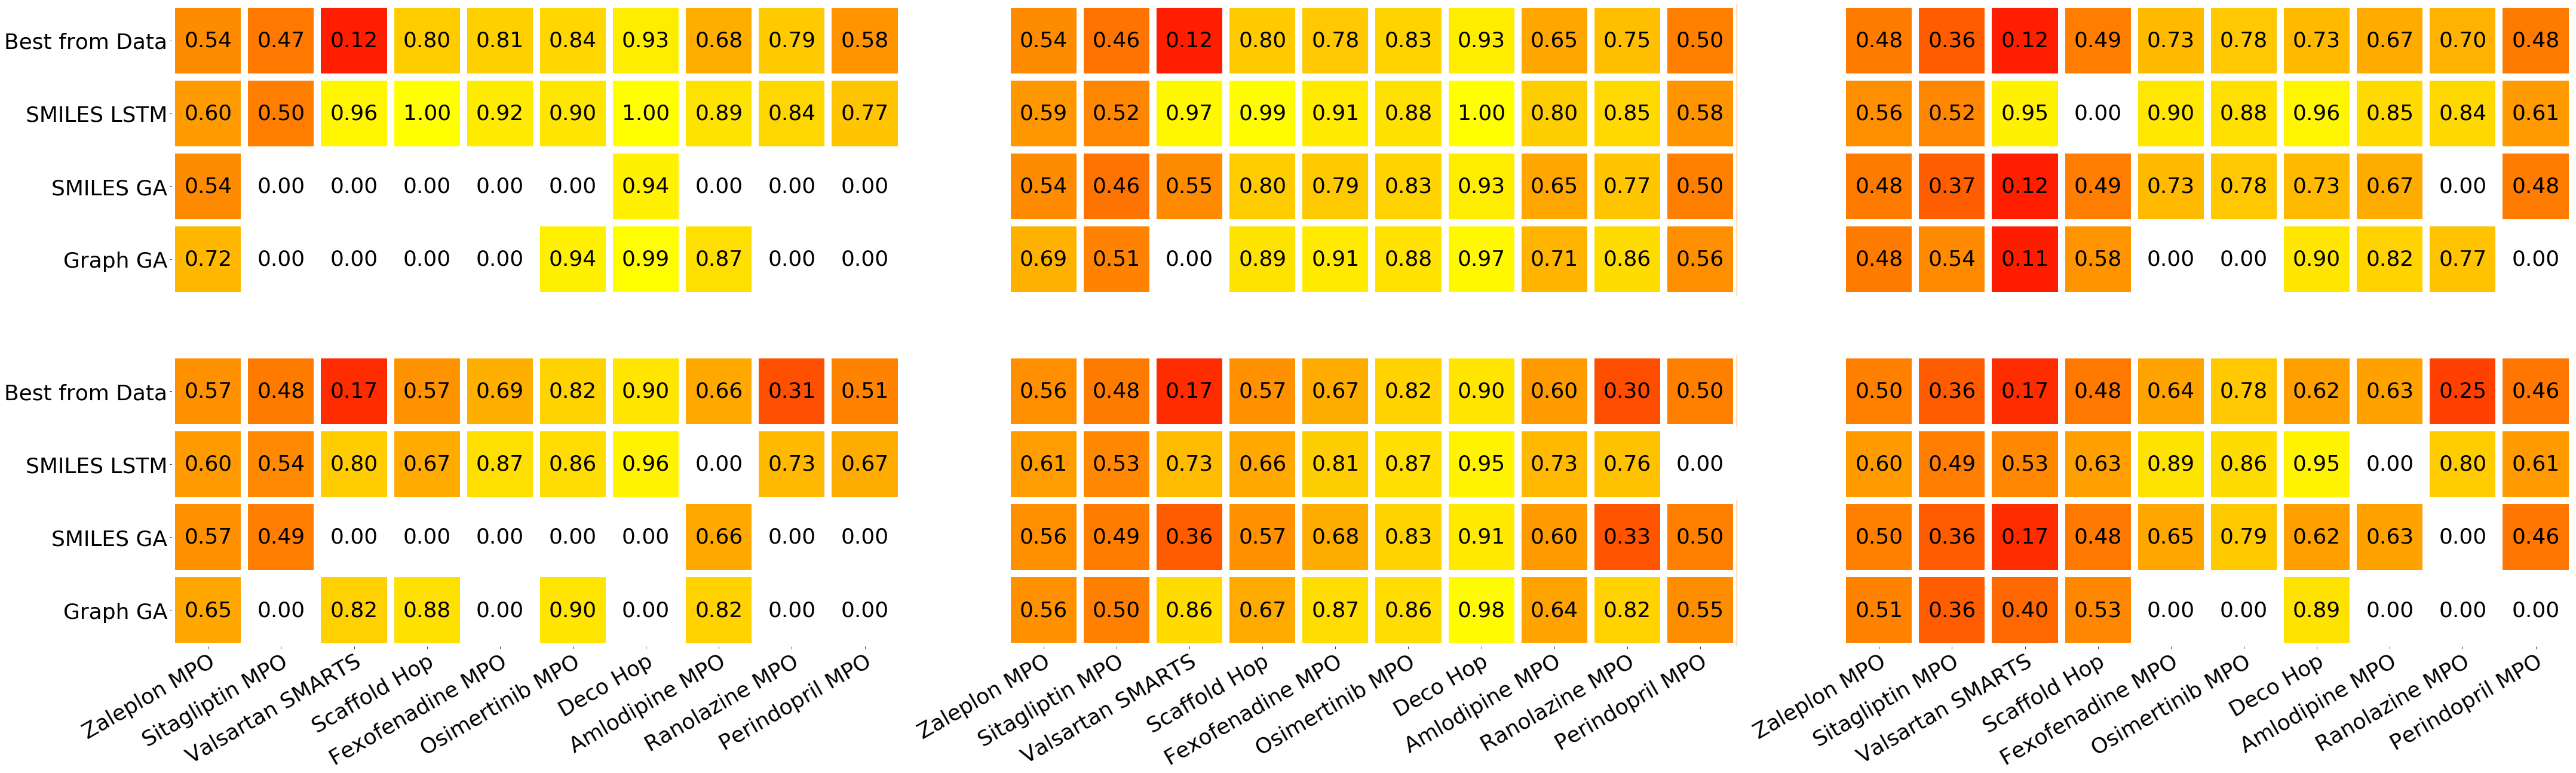

In [369]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(60, 20))

shrink = 1
aspect = 15
cmap = "autumn"
font_size = 36

df_goal_pivot = df_goal_hard_cwo_s10
df_goal_pivot = rename_hard_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax1, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_hard_cwa_s10
df_goal_pivot = rename_hard_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax2, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_hard_cwc_s10
df_goal_pivot = rename_hard_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax3, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=False, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_hard_mwo_s10
df_goal_pivot = rename_hard_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax4, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=True, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)

df_goal_pivot = df_goal_hard_mwa_s10
df_goal_pivot = rename_hard_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax5, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)


df_goal_pivot = df_goal_hard_mwc_s10
df_goal_pivot = rename_hard_obj(df_goal_pivot)
im, _ = heatmap(df_goal_pivot.to_numpy(), df_goal_pivot.index, df_goal_pivot.columns, ax=ax6, cbar_kw={'shrink': shrink, 'aspect': aspect}, vmin=0, vmax=1, set_xlabel=True, set_ylabel=False, set_cbar=False,
                   cmap=cmap, cbarlabel="Synthesizability", font_size=font_size)
annotate_heatmap(im, valfmt="{x:.2f}", size=font_size)



plt.tight_layout()
# plt.show()
plt.savefig('./figure/heatmap_goal_hard_obj.png')

In [427]:
threshold = 1

df_goal_trivial_cwo_s10 = calc_avg(df_goal_trivial_cwo, threshold, 'property', 'method')
df_goal_trivial_cwa_s10 = calc_avg(df_goal_trivial_cwa, threshold, 'property', 'method')
df_goal_trivial_cwc_s10 = calc_avg(df_goal_trivial_cwc, threshold, 'property', 'method')

df_goal_trivial_mwo_s10 = calc_avg(df_goal_trivial_mwo, threshold, 'property', 'method')
df_goal_trivial_mwa_s10 = calc_avg(df_goal_trivial_mwa, threshold, 'property', 'method')
df_goal_trivial_mwc_s10 = calc_avg(df_goal_trivial_mwc, threshold, 'property', 'method')


df_goal_hard_cwo_top = calc_avg(df_goal_hard_cwo, threshold, 'property', 'method')
df_goal_hard_cwa_top = calc_avg(df_goal_hard_cwa, threshold, 'property', 'method')
df_goal_hard_cwc_top = calc_avg(df_goal_hard_cwc, threshold, 'property', 'method')

df_goal_hard_mwo_top = calc_avg(df_goal_hard_mwo, threshold, 'property', 'method')
df_goal_hard_mwa_top = calc_avg(df_goal_hard_mwa, threshold, 'property', 'method')
df_goal_hard_mwc_top = calc_avg(df_goal_hard_mwc, threshold, 'property', 'method')

df_goal_trivial_cwo_synth = make_synth_data(df_goal_trivial_cwo)
df_goal_trivial_cwa_synth = make_synth_data(df_goal_trivial_cwa)
df_goal_trivial_cwc_synth = make_synth_data(df_goal_trivial_cwc)

df_goal_trivial_mwo_synth = make_synth_data(df_goal_trivial_mwo)
df_goal_trivial_mwa_synth = make_synth_data(df_goal_trivial_mwa)
df_goal_trivial_mwc_synth = make_synth_data(df_goal_trivial_mwc)

df_goal_trivial_cwo_top_s = calc_avg(df_goal_trivial_cwo_synth, threshold, 'property', 'method')
df_goal_trivial_cwa_top_s = calc_avg(df_goal_trivial_cwa_synth, threshold, 'property', 'method')
df_goal_trivial_cwc_top_s = calc_avg(df_goal_trivial_cwc_synth, threshold, 'property', 'method')

df_goal_trivial_mwo_top_s = calc_avg(df_goal_trivial_mwo_synth, threshold, 'property', 'method')
df_goal_trivial_mwa_top_s = calc_avg(df_goal_trivial_mwa_synth, threshold, 'property', 'method')
df_goal_trivial_mwc_top_s = calc_avg(df_goal_trivial_mwc_synth, threshold, 'property', 'method')

df_goal_hard_cwo_synth = make_synth_data(df_goal_hard_cwo)
df_goal_hard_cwa_synth = make_synth_data(df_goal_hard_cwa)
df_goal_hard_cwc_synth = make_synth_data(df_goal_hard_cwc)

df_goal_hard_mwo_synth = make_synth_data(df_goal_hard_mwo)
df_goal_hard_mwa_synth = make_synth_data(df_goal_hard_mwa)
df_goal_hard_mwc_synth = make_synth_data(df_goal_hard_mwc)

df_goal_hard_cwo_top_s = calc_avg(df_goal_hard_cwo_synth, threshold, 'property', 'method')
df_goal_hard_cwa_top_s = calc_avg(df_goal_hard_cwa_synth, threshold, 'property', 'method')
df_goal_hard_cwc_top_s = calc_avg(df_goal_hard_cwc_synth, threshold, 'property', 'method')

df_goal_hard_mwo_top_s = calc_avg(df_goal_hard_mwo_synth, threshold, 'property', 'method')
df_goal_hard_mwa_top_s = calc_avg(df_goal_hard_mwa_synth, threshold, 'property', 'method')
df_goal_hard_mwc_top_s = calc_avg(df_goal_hard_mwc_synth, threshold, 'property', 'method')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


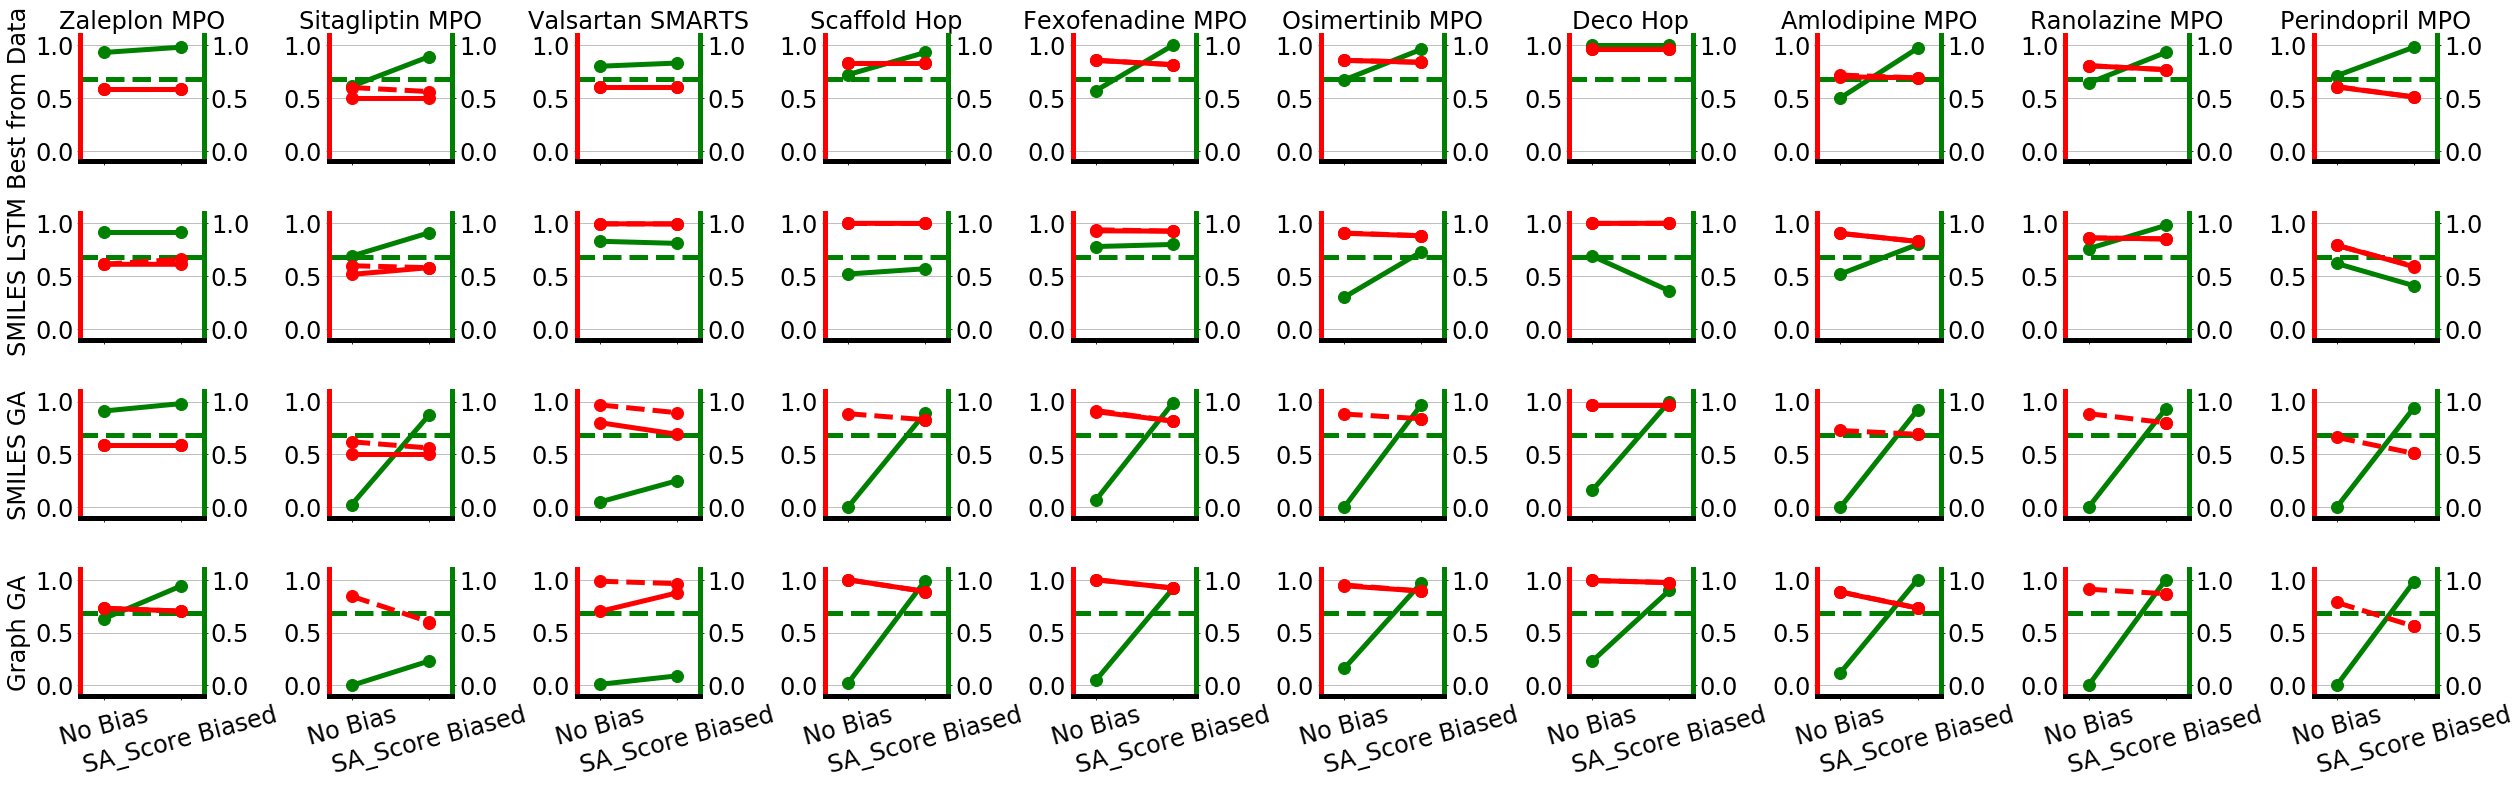

In [469]:
columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
         'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO']
index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']
baseline = 0.683
x_labels = ['No Bias', 'SA_Score Biased']
font_size = 24

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20), 
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30), (ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40)) = plt.subplots(4, 10, figsize=(35, 11))

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40]

df_obj_top1 = rename_hard_obj(df_goal_hard_cwo_top)
df_obj_top_s1 = rename_hard_obj(df_goal_hard_cwo_top_s)
df_synth1 = rename_hard(make_pivot(df_goal_hard_cwo, name=''))

df_obj_top2 = rename_hard_obj(df_goal_hard_cwa_top)
df_obj_top_s2 = rename_hard_obj(df_goal_hard_cwa_top_s)
df_synth2 = rename_hard(make_pivot(df_goal_hard_cwa, name=''))

ax_index = 0
for i in range(len(index)):
    for j in range(len(columns)):
        method = index[i]
        objective = columns[j]
        synth = np.array([df_synth1[objective][method], df_synth2[objective][method]])
        obj = np.array([df_obj_top1[objective][method], df_obj_top2[objective][method]])
        obj_s = np.array([df_obj_top_s1[objective][method], df_obj_top_s2[objective][method]])
        if ax_index == 0:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, set_y1=True, y1_label=index[0], title=objective)
        elif ax_index == 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[1], title=objective)
        elif ax_index == 20:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[2], title=objective)
        elif ax_index == 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, set_y1=True, y1_label=index[3], title=objective)
        elif ax_index < 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, title=objective)
        elif 10 <= ax_index < 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, title=objective)
        elif ax_index < 40:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, title=objective)
        ax_index += 1

plt.tight_layout()
# plt.show()
plt.savefig('./figure/plot_change_goal_hard_ca.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


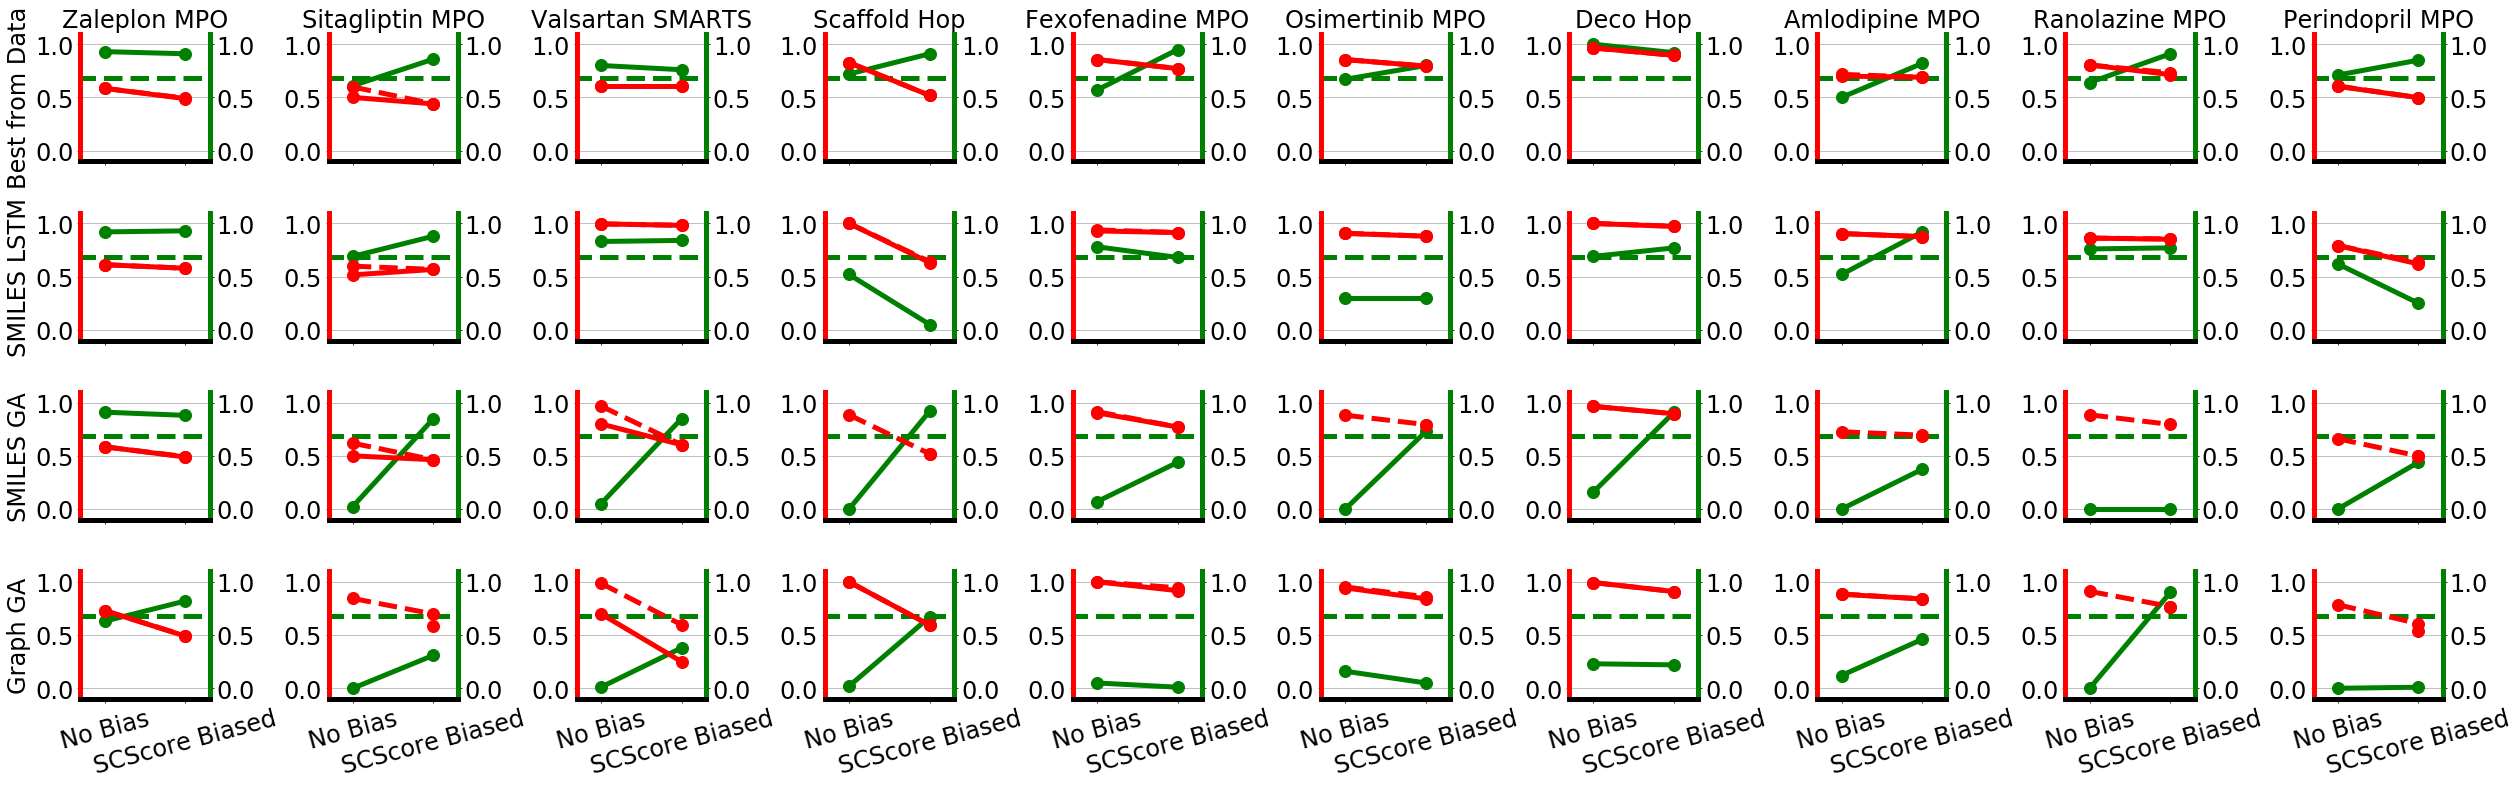

In [470]:
columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
         'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO']
index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']
baseline = 0.683
x_labels = ['No Bias', 'SCScore Biased']
font_size = 24

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20), 
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30), (ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40)) = plt.subplots(4, 10, figsize=(35, 11))

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40]

df_obj_top1 = rename_hard_obj(df_goal_hard_cwo_top)
df_obj_top_s1 = rename_hard_obj(df_goal_hard_cwo_top_s)
df_synth1 = rename_hard(make_pivot(df_goal_hard_cwo, name=''))

df_obj_top2 = rename_hard_obj(df_goal_hard_cwc_top)
df_obj_top_s2 = rename_hard_obj(df_goal_hard_cwc_top_s)
df_synth2 = rename_hard(make_pivot(df_goal_hard_cwc, name=''))

ax_index = 0
for i in range(len(index)):
    for j in range(len(columns)):
        method = index[i]
        objective = columns[j]
        synth = np.array([df_synth1[objective][method], df_synth2[objective][method]])
        obj = np.array([df_obj_top1[objective][method], df_obj_top2[objective][method]])
        obj_s = np.array([df_obj_top_s1[objective][method], df_obj_top_s2[objective][method]])
        if ax_index == 0:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, set_y1=True, y1_label=index[0], title=objective)
        elif ax_index == 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[1], title=objective)
        elif ax_index == 20:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[2], title=objective)
        elif ax_index == 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, set_y1=True, y1_label=index[3], title=objective)
        elif ax_index < 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, title=objective)
        elif 10 <= ax_index < 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, title=objective)
        elif ax_index < 40:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, title=objective)
        ax_index += 1

plt.tight_layout()
# plt.show()
plt.savefig('./figure/plot_change_goal_hard_cc.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


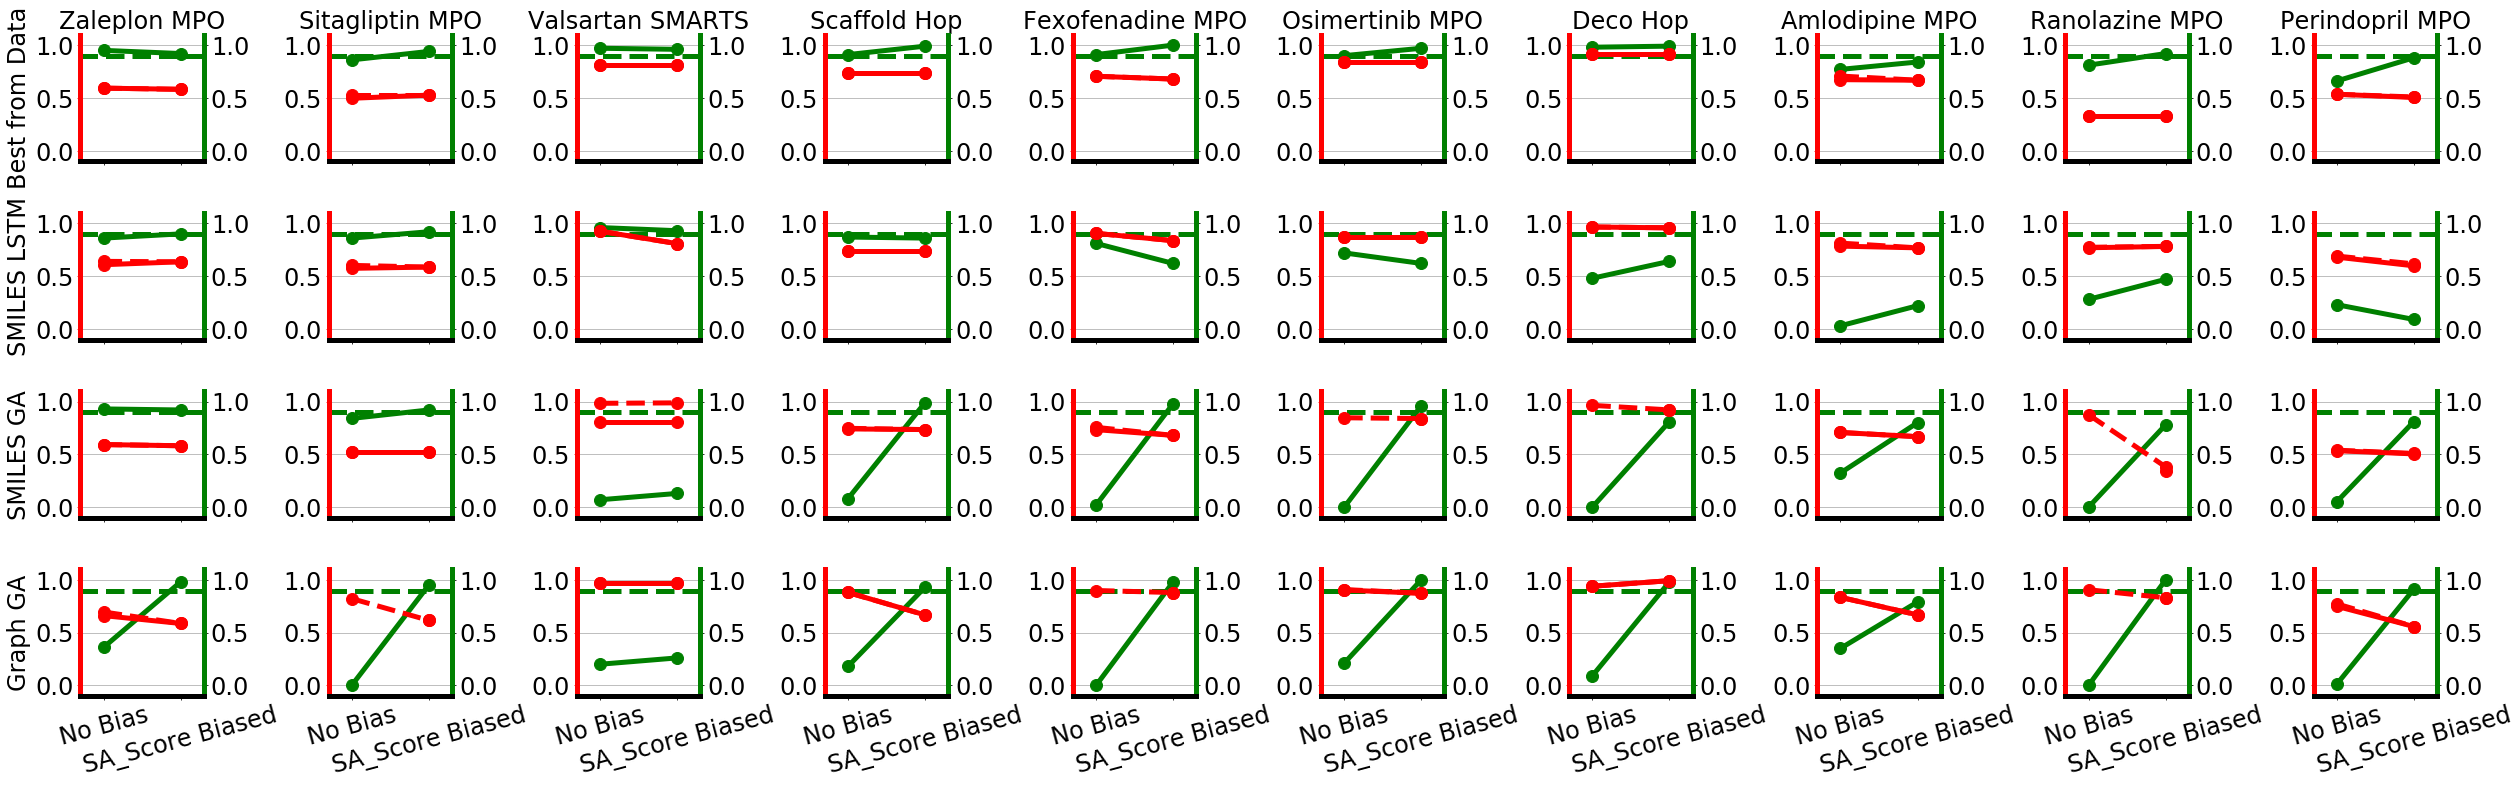

In [471]:
columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
         'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO']
index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']
baseline = 0.898
x_labels = ['No Bias', 'SA_Score Biased']
font_size = 24

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20), 
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30), (ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40)) = plt.subplots(4, 10, figsize=(35, 11))

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40]

df_obj_top1 = rename_hard_obj(df_goal_hard_mwo_top)
df_obj_top_s1 = rename_hard_obj(df_goal_hard_mwo_top_s)
df_synth1 = rename_hard(make_pivot(df_goal_hard_mwo, name=''))

df_obj_top2 = rename_hard_obj(df_goal_hard_mwa_top)
df_obj_top_s2 = rename_hard_obj(df_goal_hard_mwa_top_s)
df_synth2 = rename_hard(make_pivot(df_goal_hard_mwa, name=''))

ax_index = 0
for i in range(len(index)):
    for j in range(len(columns)):
        method = index[i]
        objective = columns[j]
        synth = np.array([df_synth1[objective][method], df_synth2[objective][method]])
        obj = np.array([df_obj_top1[objective][method], df_obj_top2[objective][method]])
        obj_s = np.array([df_obj_top_s1[objective][method], df_obj_top_s2[objective][method]])
        if ax_index == 0:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, set_y1=True, y1_label=index[0], title=objective)
        elif ax_index == 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[1], title=objective)
        elif ax_index == 20:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[2], title=objective)
        elif ax_index == 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, set_y1=True, y1_label=index[3], title=objective)
        elif ax_index < 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, title=objective)
        elif 10 <= ax_index < 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, title=objective)
        elif ax_index < 40:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, title=objective)
        ax_index += 1

plt.tight_layout()
# plt.show()
plt.savefig('./figure/plot_change_goal_hard_ma.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


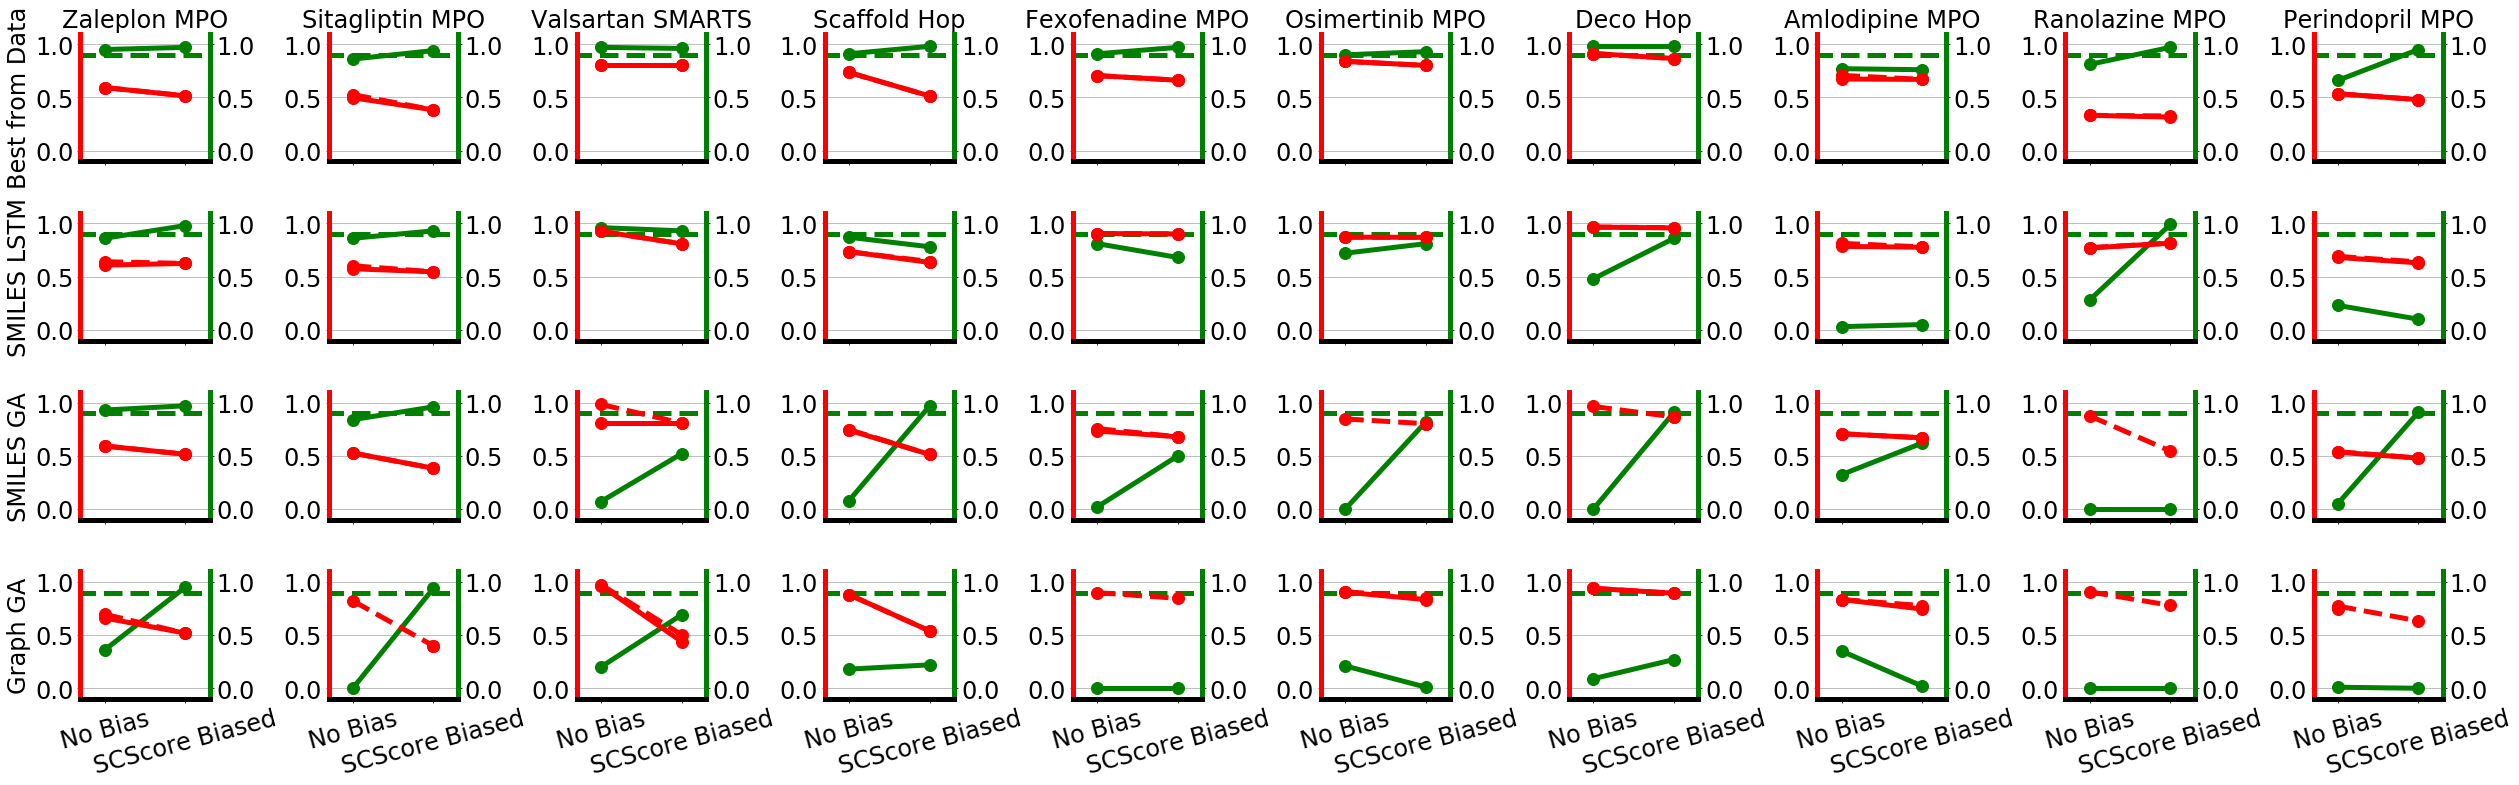

In [472]:
columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
         'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO']
index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']
baseline = 0.898
x_labels = ['No Bias', 'SCScore Biased']
font_size = 24

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20), 
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30), (ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40)) = plt.subplots(4, 10, figsize=(35, 11))

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40]

df_obj_top1 = rename_hard_obj(df_goal_hard_mwo_top)
df_obj_top_s1 = rename_hard_obj(df_goal_hard_mwo_top_s)
df_synth1 = rename_hard(make_pivot(df_goal_hard_mwo, name=''))

df_obj_top2 = rename_hard_obj(df_goal_hard_mwc_top)
df_obj_top_s2 = rename_hard_obj(df_goal_hard_mwc_top_s)
df_synth2 = rename_hard(make_pivot(df_goal_hard_mwc, name=''))

ax_index = 0
for i in range(len(index)):
    for j in range(len(columns)):
        method = index[i]
        objective = columns[j]
        synth = np.array([df_synth1[objective][method], df_synth2[objective][method]])
        obj = np.array([df_obj_top1[objective][method], df_obj_top2[objective][method]])
        obj_s = np.array([df_obj_top_s1[objective][method], df_obj_top_s2[objective][method]])
        if ax_index == 0:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, set_y1=True, y1_label=index[0], title=objective)
        elif ax_index == 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[1], title=objective)
        elif ax_index == 20:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[2], title=objective)
        elif ax_index == 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, set_y1=True, y1_label=index[3], title=objective)
        elif ax_index < 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, title=objective)
        elif 10 <= ax_index < 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, title=objective)
        elif ax_index < 40:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, title=objective)
        ax_index += 1

plt.tight_layout()
# plt.show()
plt.savefig('./figure/plot_change_goal_hard_mc.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


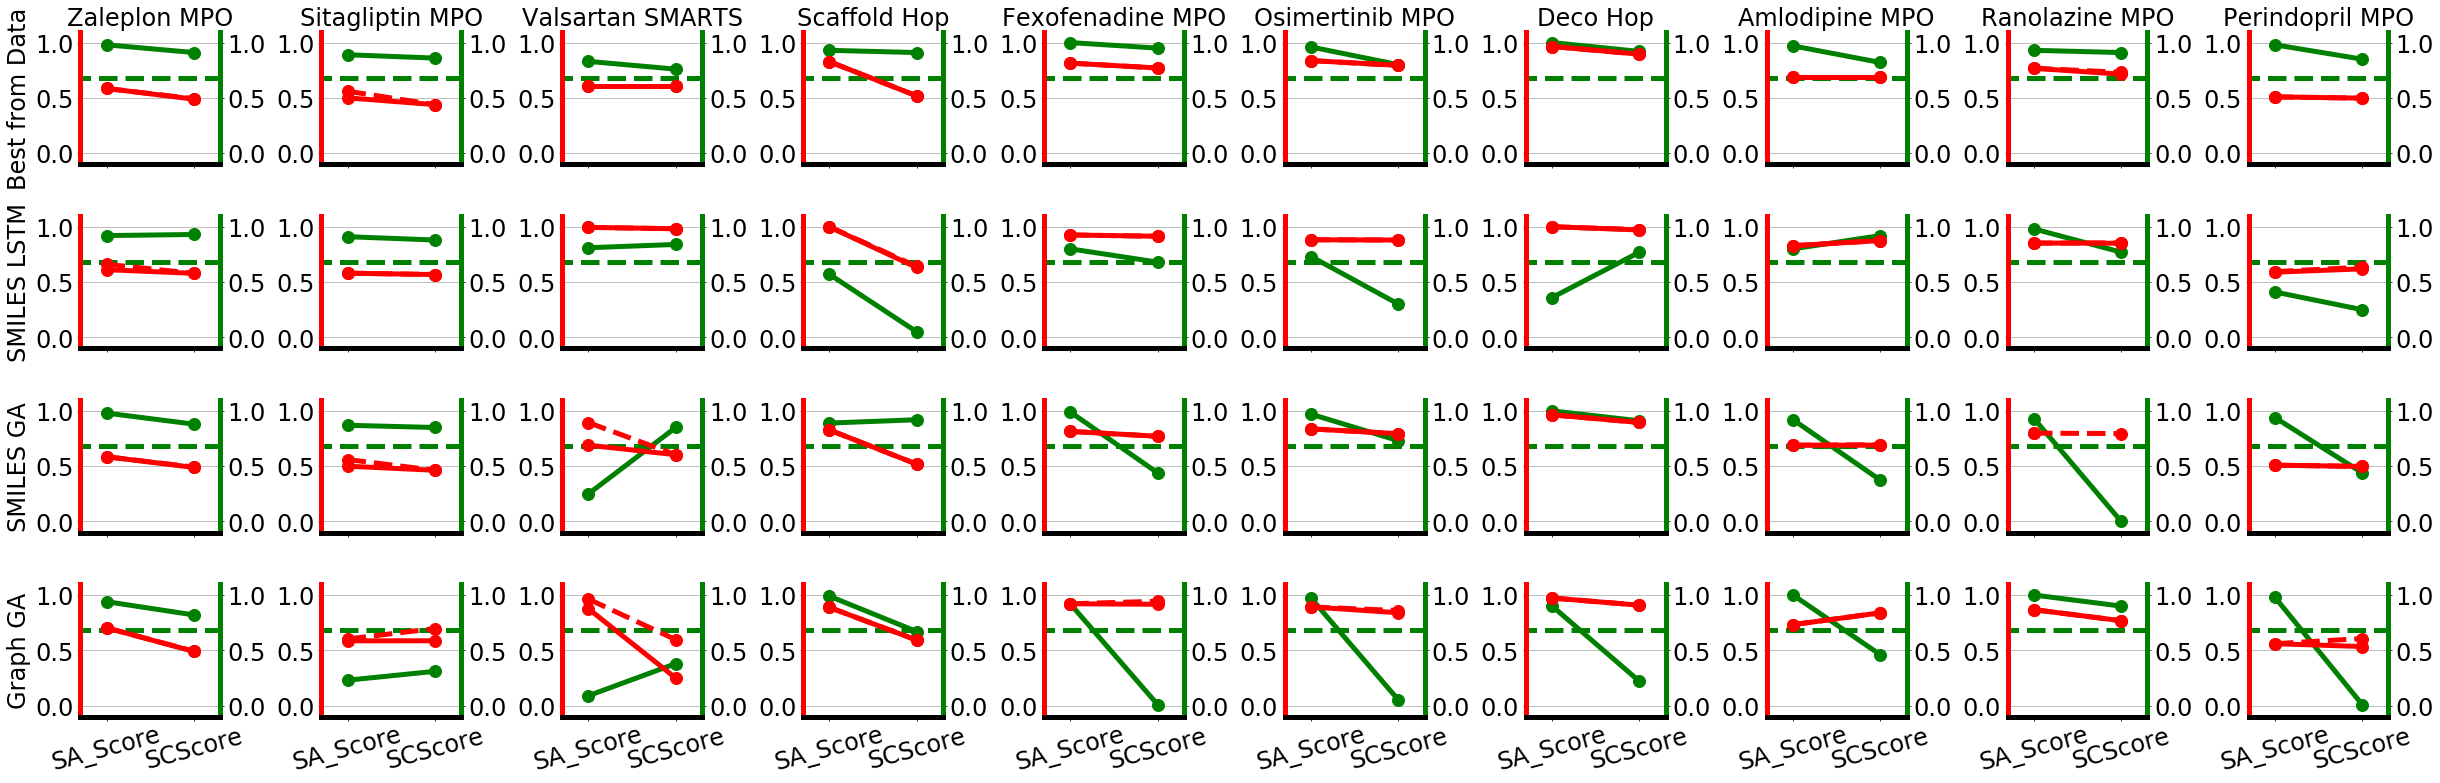

In [459]:
columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
         'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO']
index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']
baseline = 0.683
x_labels = ['SA_Score', 'SCScore']
font_size = 24

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20), 
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30), (ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40)) = plt.subplots(4, 10, figsize=(34, 11))

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40]

df_obj_top1 = rename_hard_obj(df_goal_hard_cwa_top)
df_obj_top_s1 = rename_hard_obj(df_goal_hard_cwa_top_s)
df_synth1 = rename_hard(make_pivot(df_goal_hard_cwa, name=''))

df_obj_top2 = rename_hard_obj(df_goal_hard_cwc_top)
df_obj_top_s2 = rename_hard_obj(df_goal_hard_cwc_top_s)
df_synth2 = rename_hard(make_pivot(df_goal_hard_cwc, name=''))

ax_index = 0
for i in range(len(index)):
    for j in range(len(columns)):
        method = index[i]
        objective = columns[j]
        synth = np.array([df_synth1[objective][method], df_synth2[objective][method]])
        obj = np.array([df_obj_top1[objective][method], df_obj_top2[objective][method]])
        obj_s = np.array([df_obj_top_s1[objective][method], df_obj_top_s2[objective][method]])
        if ax_index == 0:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, set_y1=True, y1_label=index[0], title=objective)
        elif ax_index == 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[1], title=objective)
        elif ax_index == 20:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[2], title=objective)
        elif ax_index == 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, set_y1=True, y1_label=index[3], title=objective)
        elif ax_index < 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, title=objective)
        elif 10 <= ax_index < 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, title=objective)
        elif ax_index < 40:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, title=objective)
        ax_index += 1

plt.tight_layout()
# plt.show()
plt.savefig('./figure/plot_change_goal_hard_cac.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


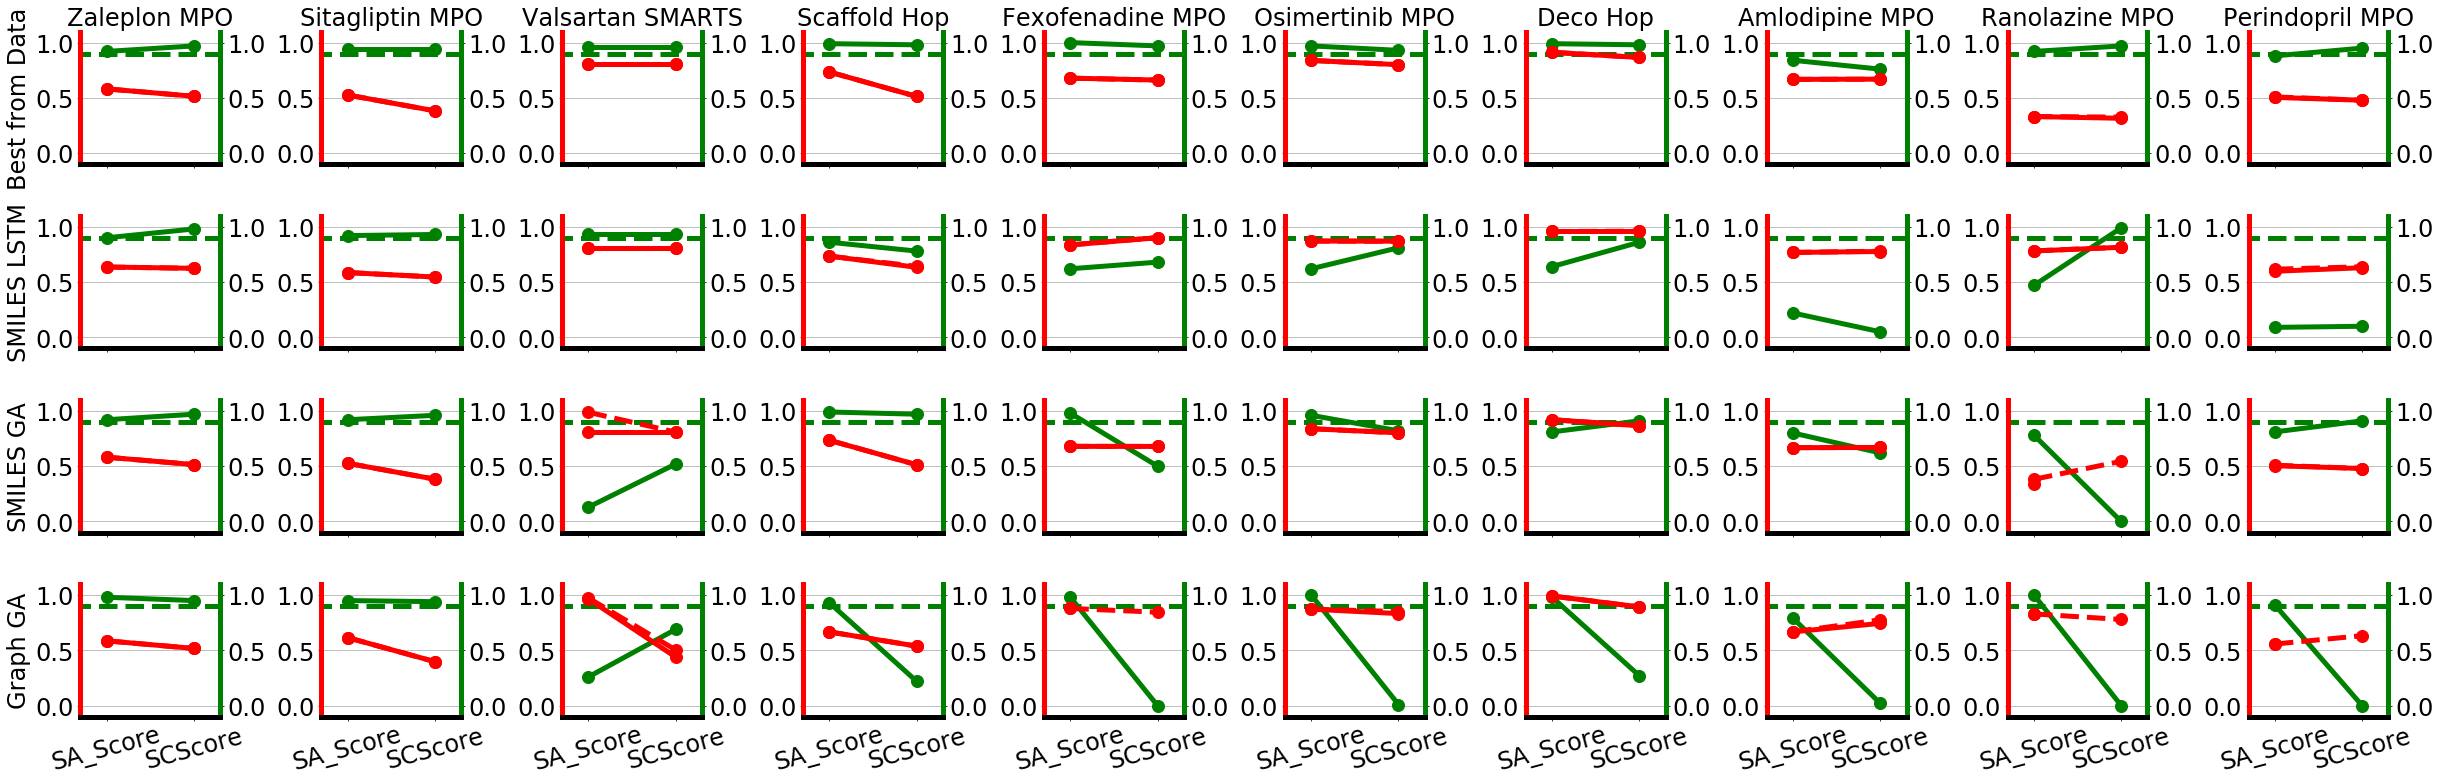

In [458]:
columns=['Zaleplon MPO', 'Sitagliptin MPO', 'Valsartan SMARTS', 'Scaffold Hop', 'Fexofenadine MPO', 'Osimertinib MPO', 
         'Deco Hop', 'Amlodipine MPO', 'Ranolazine MPO', 'Perindopril MPO']
index=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']
baseline = 0.898
x_labels = ['SA_Score', 'SCScore']
font_size = 24

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20), 
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30), (ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40)) = plt.subplots(4, 10, figsize=(34, 11))

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40]

df_obj_top1 = rename_hard_obj(df_goal_hard_mwa_top)
df_obj_top_s1 = rename_hard_obj(df_goal_hard_mwa_top_s)
df_synth1 = rename_hard(make_pivot(df_goal_hard_mwa, name=''))

df_obj_top2 = rename_hard_obj(df_goal_hard_mwc_top)
df_obj_top_s2 = rename_hard_obj(df_goal_hard_mwc_top_s)
df_synth2 = rename_hard(make_pivot(df_goal_hard_mwc, name=''))

ax_index = 0
for i in range(len(index)):
    for j in range(len(columns)):
        method = index[i]
        objective = columns[j]
        synth = np.array([df_synth1[objective][method], df_synth2[objective][method]])
        obj = np.array([df_obj_top1[objective][method], df_obj_top2[objective][method]])
        obj_s = np.array([df_obj_top_s1[objective][method], df_obj_top_s2[objective][method]])
        if ax_index == 0:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, set_y1=True, y1_label=index[0], title=objective)
        elif ax_index == 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[1], title=objective)
        elif ax_index == 20:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, set_y1=True, y1_label=index[2], title=objective)
        elif ax_index == 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, set_y1=True, y1_label=index[3], title=objective)
        elif ax_index < 10:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=True, set_x=False, title=objective)
        elif 10 <= ax_index < 30:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=False, title=objective)
        elif ax_index < 40:
            plot_change(synth, obj, obj_s, x_labels, baseline, ax1=axs[ax_index], font_size=font_size, set_title=False, set_x=True, title=objective)
        ax_index += 1

plt.tight_layout()
# plt.show()
plt.savefig('./figure/plot_change_goal_hard_mac.png')